In [17]:
# Force reload of modules during development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv

import sys
sys.path.append(str(Path.cwd().parent))

from ingestion.database import get_connection
from features.database import get_raw_series, get_features, upsert_features
from features.compute import compute_all_features
from features.basic import compute_all_basic_features
from features.cleaning import validate_data_quality

In [19]:
# Load environment and connect to database
load_dotenv()
db_password = os.getenv('DB_PASSWORD')

conn = get_connection(password=db_password)
print("Connected to database")

Connected to database


In [20]:
# Inspect raw data
df_raw = get_raw_series(conn, ticker='^GSPC', start_date='2010-01-01')
print(f"Loaded {len(df_raw)} rows for GSPC")
print(f"\nDate range: {df_raw['dt'].min()} to {df_raw['dt'].max()}")
df_raw.head(10)

Loaded 4012 rows for GSPC

Date range: 2010-01-04 to 2025-12-12


,ticker,asset_class,dt,value,source
0,^GSPC,EQUITY,2010-01-04,1132.989990,yfinance
1,^GSPC,EQUITY,2010-01-05,1136.520020,yfinance
2,^GSPC,EQUITY,2010-01-06,1137.140015,yfinance
3,^GSPC,EQUITY,2010-01-07,1141.689941,yfinance
4,^GSPC,EQUITY,2010-01-08,1144.979980,yfinance
5,^GSPC,EQUITY,2010-01-11,1146.979980,yfinance
6,^GSPC,EQUITY,2010-01-12,1136.219971,yfinance
7,^GSPC,EQUITY,2010-01-13,1145.680054,yfinance
8,^GSPC,EQUITY,2010-01-14,1148.459961,yfinance
9,^GSPC,EQUITY,2010-01-15,1136.030029,yfinance


In [21]:
# Test basic feature computation for a single ticker
df_test = df_raw[['dt', 'value']].copy()
df_test = df_test.set_index('dt')

features = compute_all_basic_features(df_test, '^GSPC', 'EQUITY').set_index('dt')
print(f"Computed {len(features)} features")
print(f"Unique features: {features['feature'].unique()}")
features.head(10)

Computed 35902 features
Unique features: ['^GSPC_LEVEL' '^GSPC_RET_1D' '^GSPC_RET_5D' '^GSPC_RET_20D'
 '^GSPC_RET_60D' '^GSPC_MOM_20D' '^GSPC_MOM_60D' '^GSPC_VOL_20D'
 '^GSPC_VOL_60D']


,ticker,asset_class,feature,value
dt,,,,
2010-01-04,^GSPC,EQUITY,^GSPC_LEVEL,1132.989990
2010-01-05,^GSPC,EQUITY,^GSPC_LEVEL,1136.520020
2010-01-06,^GSPC,EQUITY,^GSPC_LEVEL,1137.140015
2010-01-07,^GSPC,EQUITY,^GSPC_LEVEL,1141.689941
2010-01-08,^GSPC,EQUITY,^GSPC_LEVEL,1144.979980
2010-01-11,^GSPC,EQUITY,^GSPC_LEVEL,1146.979980
2010-01-12,^GSPC,EQUITY,^GSPC_LEVEL,1136.219971
2010-01-13,^GSPC,EQUITY,^GSPC_LEVEL,1145.680054
2010-01-14,^GSPC,EQUITY,^GSPC_LEVEL,1148.459961


In [22]:
features[features['feature'] == '^GSPC_RET_20D']['value']

dt
2010-02-02   -0.026187
2010-02-03   -0.034526
2010-02-04   -0.065102
2010-02-05   -0.066130
2010-02-08   -0.077067
                ...   
2025-12-08    0.017493
2025-12-09    0.001183
2025-12-10    0.005853
2025-12-11    0.007310
2025-12-12    0.013346
Name: value, Length: 3992, dtype: float64

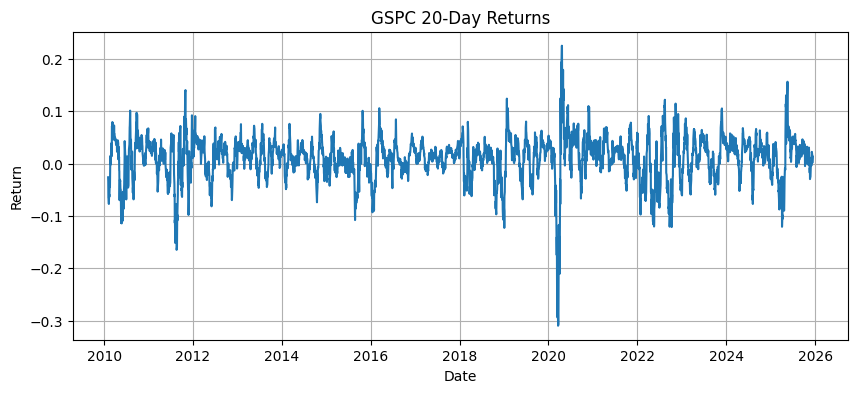

In [23]:
# Visualize feature distributions
import matplotlib.pyplot as plt

if '^GSPC_RET_20D' in features['feature'].values:
    ret_20d = features[features['feature'] == '^GSPC_RET_20D']['value']
    plt.figure(figsize=(10, 4))
    plt.plot(ret_20d.index, ret_20d.values)  # type: ignore
    plt.title('GSPC 20-Day Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()

In [24]:
# Run full feature computation pipeline
# This computes all features for all tickers and stores them in the database

result = compute_all_features(
    conn,
    version='V2_FWD_FILL',
    start_date='2010-01-01',
    ticker_filter=None,  # None = all tickers
    forward_fill=True,
    business_days_only=True
)

print("\nFeature computation summary:")
print(result)

Starting feature computation (version: V2_FWD_FILL)...
Loading raw data...
Loaded 54 tickers
Cleaning and preparing data...
Computing basic features...
  Computed 1357932 basic features
Computing spread features...
  Computed 52350 spread features
Computing ratio features...
  Computed 46583 ratio features
Computing global aggregates...
  Computed 38439 aggregate features
Combining all features...
Total features computed: 1,495,304
Unique features: 376
Date range: 2010-01-01 to 2025-12-14
Smart forward-filling features based on natural frequency...
  Before: 1,495,304 rows
  Business days in range: 4161 days
  Processed 50/376 features
  Processed 100/376 features
  Processed 150/376 features
  Processed 200/376 features
  Processed 250/376 features
  Processed 300/376 features
  Processed 350/376 features
  Processed 376/376 features

  Frequency distribution:
    DAILY: 360 features
    WEEKLY: 8 features
    MONTHLY: 7 features
    QUARTERLY: 1 features

  After: 1,534,055 rows
  Ad

In [34]:
# Inspect computed features
df_features = get_features(conn, version='V2_FWD_FILL', start_date='2010-01-01')
print(f"Loaded {len(df_features)} feature rows")
print(f"Unique features: {df_features['feature'].nunique()}")
print(f"\nFeature types:")
df_features['feature'].value_counts().sort_values(ascending=True)

InterfaceError: connection already closed

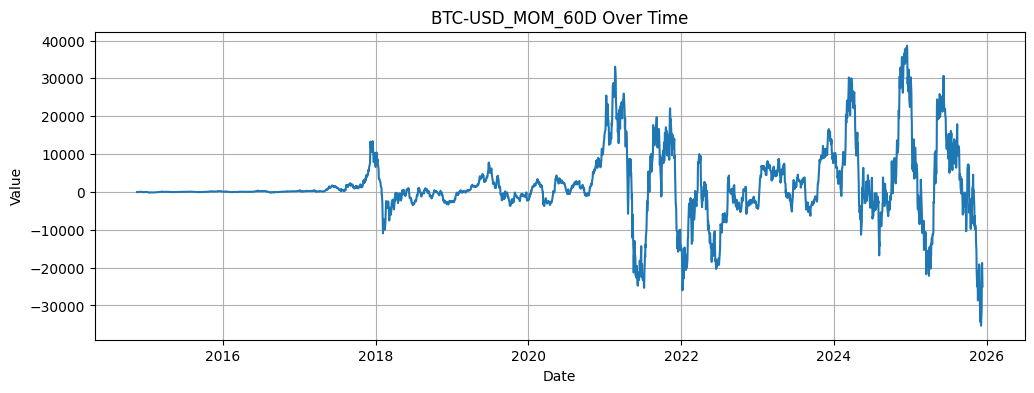


Statistics for BTC-USD_MOM_60D:
count     2890.000000
mean      1480.876930
std       8884.718015
min     -35364.773438
25%      -1378.161987
50%        116.975647
75%       3399.359009
max      38629.882812
Name: value, dtype: float64


In [26]:
# Example: View specific feature over time
feature_name = 'BTC-USD_MOM_60D'  # Change to any feature name
df_feature = df_features[df_features['feature'] == feature_name].sort_values('dt')  # type: ignore

if not df_feature.empty:
    plt.figure(figsize=(12, 4))
    plt.plot(pd.to_datetime(df_feature['dt']), df_feature['value'])
    plt.title(f'{feature_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
    
    print(f"\nStatistics for {feature_name}:")
    print(df_feature['value'].describe())
else:
    print(f"Feature {feature_name} not found")

In [27]:
# View global aggregate features
global_features = df_features[df_features['ticker'] == 'GLOBAL']
print(f"Global features: {global_features['feature'].unique()}") # type: ignore
print(f"\nSample global features:")
global_features.head(10)

Global features: ['FX_AUD_JPY' 'GLOBAL_FINANCIAL_CONDITIONS' 'COMMODITY_GOLD_OIL'
 'CREDIT_HY_SPREAD' 'CREDIT_IG_SPREAD' 'EQUITY_EM_VS_US'
 'GLOBAL_INFLATION_EXPECTATIONS' 'GLOBAL_YIELD_CURVE_SLOPE'
 'REAL_RATE_10Y' 'STYLE_CYCLICAL_VS_DEFENSIVE' 'STYLE_GROWTH_VS_VALUE'
 'STYLE_SMALL_VS_LARGE' 'VOL_VIX_LEVEL' 'VOL_VVIX_VIX' 'YCURVE_2S10S'
 'YCURVE_2S5S' 'YCURVE_5S30S' 'GLOBAL_INFLATION_REALIZED'
 'GLOBAL_GROWTH_SIGNAL' 'CREDIT_HY_CHG_20D' 'CREDIT_IG_CHG_20D'
 'GLOBAL_EQUITY_MOMENTUM' 'GLOBAL_RISK_APPETITE']

Sample global features:


,dt,ticker,asset_class,feature,value,version
6,2010-01-01,GLOBAL,MACRO,FX_AUD_JPY,0.009669,V2_FWD_FILL
7,2010-01-01,GLOBAL,MACRO,GLOBAL_FINANCIAL_CONDITIONS,-0.178560,V2_FWD_FILL
39,2010-01-04,GLOBAL,MACRO,COMMODITY_GOLD_OIL,13.712427,V2_FWD_FILL
40,2010-01-04,GLOBAL,MACRO,CREDIT_HY_SPREAD,6.340000,V2_FWD_FILL
41,2010-01-04,GLOBAL,MACRO,CREDIT_IG_SPREAD,1.880000,V2_FWD_FILL
42,2010-01-04,GLOBAL,MACRO,EQUITY_EM_VS_US,0.027172,V2_FWD_FILL
43,2010-01-04,GLOBAL,MACRO,FX_AUD_JPY,0.009865,V2_FWD_FILL
44,2010-01-04,GLOBAL,MACRO,GLOBAL_FINANCIAL_CONDITIONS,-0.178560,V2_FWD_FILL
45,2010-01-04,GLOBAL,MACRO,GLOBAL_INFLATION_EXPECTATIONS,2.255000,V2_FWD_FILL
46,2010-01-04,GLOBAL,MACRO,GLOBAL_YIELD_CURVE_SLOPE,2.760000,V2_FWD_FILL


In [40]:
# Reconnect to database if needed
try:
    # Test if connection is still alive
    cursor = conn.cursor()
    cursor.execute("SELECT 1")
    cursor.close()
    print("✅ Database connection is active")
except:
    print("⚠️  Connection closed, reconnecting...")
    conn = get_connection(password=db_password)
    print("✅ Reconnected to database")

⚠️  Connection closed, reconnecting...
✅ Reconnected to database


# Data Quality Diagnostics

Run these cells to check for missing values and validate data completeness.

In [41]:
# 1. Categorize features by frequency and check if sparse data is expected

def categorize_feature_frequency(conn, version='V2_FWD_FILL'):
    """
    Automatically detect the frequency of each feature.
    """
    query = """
    SELECT 
        feature,
        ticker,
        asset_class,
        dt
    FROM macro.features
    WHERE version = %s
    ORDER BY feature, dt
    """
    
    df = pd.read_sql(query, conn, params=[version])
    df['dt'] = pd.to_datetime(df['dt'])
    
    results = []
    
    for feature in df['feature'].unique():
        feature_df = df[df['feature'] == feature].sort_values('dt')
        ticker = feature_df['ticker'].iloc[0]
        asset_class = feature_df['asset_class'].iloc[0]
        
        # Calculate median gap between consecutive observations
        date_diffs = feature_df['dt'].diff().dropna()
        median_gap = date_diffs.median().days if len(date_diffs) > 0 else 0
        
        # Categorize frequency
        if median_gap <= 5:
            frequency = 'DAILY'
            expected_behavior = 'Should be nearly complete'
        elif 5 < median_gap <= 10:
            frequency = 'WEEKLY'
            expected_behavior = 'Weekly updates'
        elif 20 <= median_gap <= 35:
            frequency = 'MONTHLY'
            expected_behavior = 'Sparse OK - monthly releases'
        elif 80 <= median_gap <= 100:
            frequency = 'QUARTERLY'
            expected_behavior = 'Sparse OK - quarterly releases'
        elif median_gap > 100:
            frequency = 'ANNUAL'
            expected_behavior = 'Very sparse - annual data'
        else:
            frequency = 'IRREGULAR'
            expected_behavior = 'Check data quality'
        
        # Count observations
        first_date = feature_df['dt'].min()
        last_date = feature_df['dt'].max()
        years_span = (last_date - first_date).days / 365.25
        obs_per_year = len(feature_df) / years_span if years_span > 0 else 0
        
        results.append({
            'feature': feature,
            'ticker': ticker,
            'asset_class': asset_class,
            'frequency': frequency,
            'median_gap_days': median_gap,
            'observations': len(feature_df),
            'obs_per_year': round(obs_per_year, 1),
            'expected_behavior': expected_behavior,
            'first_date': first_date.date(),
            'last_date': last_date.date()
        })
    
    results_df = pd.DataFrame(results)
    
    # Summary by frequency
    print("="*80)
    print("FEATURE FREQUENCY ANALYSIS")
    print("="*80)
    print(f"\nTotal features: {len(results_df)}")
    print(f"\nFrequency distribution:")
    print(results_df['frequency'].value_counts())
    print(f"\nObservations per year by frequency:")
    print(results_df.groupby('frequency')['obs_per_year'].describe())
    
    return results_df

# Run frequency analysis
df_freq = categorize_feature_frequency(conn, version='V2_FWD_FILL')

# Show by frequency type
print("\n" + "="*80)
print("QUARTERLY DATA (Sparse is expected)")
print("="*80)
quarterly = df_freq[df_freq['frequency'] == 'QUARTERLY']
if len(quarterly) > 0:
    print(quarterly[['feature', 'ticker', 'observations', 'obs_per_year', 'median_gap_days']])
else:
    print("No quarterly features found")

print("\n" + "="*80)
print("MONTHLY DATA (Sparse is expected)")
print("="*80)
monthly = df_freq[df_freq['frequency'] == 'MONTHLY']
if len(monthly) > 0:
    print(monthly[['feature', 'ticker', 'observations', 'obs_per_year', 'median_gap_days']].head(20))
else:
    print("No monthly features found")

print("\n" + "="*80)
print("DAILY DATA - Check for actual gaps")
print("="*80)
daily = df_freq[df_freq['frequency'] == 'DAILY']
# For daily data, low obs_per_year might indicate real problems
potential_issues = daily[daily['obs_per_year'] < 200]  # Less than 200 trading days/year
if len(potential_issues) > 0:
    print("⚠️  These daily features might have data quality issues:")
    print(potential_issues[['feature', 'ticker', 'observations', 'obs_per_year']])
else:
    print("✅ All daily features look good!")

df_freq.sort_values(['frequency', 'ticker'])


/var/folders/7m/_v42_c3x3pxc0myzbkfdk97h0000gn/T/ipykernel_32399/3410393818.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


FEATURE FREQUENCY ANALYSIS

Total features: 376

Frequency distribution:
frequency
DAILY    376
Name: count, dtype: int64

Observations per year by frequency:
           count       mean       std    min    25%    50%    75%    max
frequency                                                               
DAILY      376.0  261.00266  0.016111  261.0  261.0  261.0  261.0  261.1

QUARTERLY DATA (Sparse is expected)
No quarterly features found

MONTHLY DATA (Sparse is expected)
No monthly features found

DAILY DATA - Check for actual gaps
✅ All daily features look good!


,feature,ticker,asset_class,frequency,median_gap_days,observations,obs_per_year,expected_behavior,first_date,last_date
0,000001.SS_LEVEL,000001.SS,EQUITY,DAILY,1,4160,261.0,Should be nearly complete,2010-01-04,2025-12-12
1,000001.SS_MOM_20D,000001.SS,EQUITY,DAILY,1,4140,261.0,Should be nearly complete,2010-02-01,2025-12-12
2,000001.SS_MOM_60D,000001.SS,EQUITY,DAILY,1,4094,261.0,Should be nearly complete,2010-04-06,2025-12-12
3,000001.SS_RET_1D,000001.SS,EQUITY,DAILY,1,4159,261.0,Should be nearly complete,2010-01-05,2025-12-12
4,000001.SS_RET_20D,000001.SS,EQUITY,DAILY,1,4140,261.0,Should be nearly complete,2010-02-01,2025-12-12
...,...,...,...,...,...,...,...,...,...,...
371,^VVIX_RET_20D,^VVIX,VOL,DAILY,1,4139,261.0,Should be nearly complete,2010-02-02,2025-12-12
372,^VVIX_RET_5D,^VVIX,VOL,DAILY,1,4155,261.0,Should be nearly complete,2010-01-11,2025-12-12
373,^VVIX_RET_60D,^VVIX,VOL,DAILY,1,4098,261.0,Should be nearly complete,2010-03-31,2025-12-12
374,^VVIX_VOL_20D,^VVIX,VOL,DAILY,1,4149,261.0,Should be nearly complete,2010-01-19,2025-12-12


In [42]:
# 2. Check for weekend/calendar day data (indicates forward-fill issues)

def check_forward_fill_behavior(conn, version='V1_BASELINE_PERIOD_FIXED'):
    """
    Check if forward-fill is creating data on weekends/holidays inappropriately.
    """
    query = """
    SELECT 
        dt,
        COUNT(DISTINCT feature) as num_features
    FROM macro.features
    WHERE version = %s
    GROUP BY dt
    ORDER BY dt
    """
    
    df = pd.read_sql(query, conn, params=[version])
    df['dt'] = pd.to_datetime(df['dt'])
    df['day_of_week'] = df['dt'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['is_weekend'] = df['day_of_week'].isin([5, 6])
    
    print("="*80)
    print("FORWARD-FILL BEHAVIOR CHECK")
    print("="*80)
    print(f"\nTotal dates in database: {len(df):,}")
    print(f"Weekend dates: {df['is_weekend'].sum()}")
    print(f"\nDay of week distribution:")
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for day_num in range(7):
        count = (df['day_of_week'] == day_num).sum()
        print(f"  {day_names[day_num]}: {count:,}")
    
    if df['is_weekend'].sum() > 0:
        print("\n⚠️  WARNING: You have data on weekends!")
        print("This explains >100% completeness in earlier analysis.")
        print("\nSample weekend dates:")
        weekend_dates = df[df['is_weekend']].head(10)
        print(weekend_dates[['dt', 'num_features']])
        print("\n💡 RECOMMENDATION: Rerun compute_all_features with business_days_only=True")
    else:
        print("\n✅ No weekend data found - forward-fill is working correctly!")
    
    return df

# Check forward-fill behavior  
date_analysis = check_forward_fill_behavior(conn, version='V2_FWD_FILL')


/var/folders/7m/_v42_c3x3pxc0myzbkfdk97h0000gn/T/ipykernel_32399/4239560513.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


FORWARD-FILL BEHAVIOR CHECK

Total dates in database: 4,161
Weekend dates: 0

Day of week distribution:
  Monday: 832
  Tuesday: 832
  Wednesday: 832
  Thursday: 832
  Friday: 833
  Saturday: 0
  Sunday: 0

✅ No weekend data found - forward-fill is working correctly!


In [30]:
# 3. Find missing dates for a specific feature (detailed gap analysis)

def find_missing_dates(conn, feature_name, version='V1_BASELINE_PERIOD_FIXED'):
    """
    Find missing business days for a specific feature.
    """
    query = """
    SELECT dt
    FROM macro.features
    WHERE feature = %s 
      AND version = %s
    ORDER BY dt
    """
    
    df = pd.read_sql(query, conn, params=[feature_name, version])
    df['dt'] = pd.to_datetime(df['dt'])
    
    if df.empty:
        print(f"Feature '{feature_name}' not found!")
        return None
    
    # Generate expected business days
    first_date = df['dt'].min()
    last_date = df['dt'].max()
    expected_dates = pd.bdate_range(start=first_date, end=last_date)
    
    # Find missing
    actual_dates = set(df['dt'])
    missing_dates = [d for d in expected_dates if d not in actual_dates]
    
    print(f"Feature: {feature_name}")
    print(f"Date range: {first_date.date()} to {last_date.date()}")
    print(f"Expected business days: {len(expected_dates):,}")
    print(f"Actual days: {len(actual_dates):,}")
    print(f"Missing days: {len(missing_dates):,}")
    print(f"Completeness: {100 * len(actual_dates) / len(expected_dates):.1f}%")
    
    if missing_dates:
        print(f"\nFirst 20 missing dates:")
        for d in missing_dates[:20]:
            print(f"  {d.date()}")
        
        if len(missing_dates) > 20:
            print(f"  ... and {len(missing_dates) - 20:,} more")
    else:
        print("\n✅ No missing dates!")
    
    return pd.DataFrame({'missing_date': missing_dates})

# Example: Check a specific feature - change this to any feature you want to inspect
missing = find_missing_dates(conn, '^GSPC_LEVEL', version='V1_BASELINE_PERIOD_FIXED')


Feature: ^GSPC_LEVEL
Date range: 2010-01-04 to 2025-12-12
Expected business days: 4,160
Actual days: 4,012
Missing days: 148
Completeness: 96.4%

First 20 missing dates:
  2010-01-18
  2010-02-15
  2010-04-02
  2010-05-31
  2010-07-05
  2010-09-06
  2010-11-25
  2010-12-24
  2011-01-17
  2011-02-21
  2011-04-22
  2011-05-30
  2011-07-04
  2011-09-05
  2011-11-24
  2011-12-26
  2012-01-02
  2012-01-16
  2012-02-20
  2012-04-06
  ... and 128 more


/var/folders/7m/_v42_c3x3pxc0myzbkfdk97h0000gn/T/ipykernel_32399/710605286.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[feature_name, version])


In [43]:
# 4. Comprehensive completeness analysis with actual vs expected counts

def analyze_feature_completeness(conn, version='V1_BASELINE_PERIOD_FIXED'):
    """
    Analyze feature start dates, coverage, and identify missing data.
    """
    
    query = """
    SELECT 
        feature,
        ticker,
        asset_class,
        dt,
        value
    FROM macro.features
    WHERE version = %s
    ORDER BY feature, ticker, dt
    """
    
    df = pd.read_sql(query, conn, params=[version])
    df['dt'] = pd.to_datetime(df['dt'])
    
    print(f"Loaded {len(df):,} feature rows")
    print(f"Date range: {df['dt'].min().date()} to {df['dt'].max().date()}")
    print(f"Unique features: {df['feature'].nunique()}\n")
    
    # Summary by feature
    summary = []
    
    for feature in df['feature'].unique():
        feature_df = df[df['feature'] == feature]
        ticker = feature_df['ticker'].iloc[0]
        asset_class = feature_df['asset_class'].iloc[0]
        
        first_date = feature_df['dt'].min()
        last_date = feature_df['dt'].max()
        actual_rows = len(feature_df)
        
        # Calculate expected business days
        all_bdays = pd.bdate_range(start=first_date, end=last_date)
        expected_rows = len(all_bdays)
        
        # Check for gaps
        feature_df_sorted = feature_df.sort_values('dt')
        date_diffs = feature_df_sorted['dt'].diff()
        max_gap = date_diffs.max().days if len(date_diffs) > 1 else 0
        gaps = (date_diffs > pd.Timedelta(days=7)).sum()  # Gaps > 1 week
        
        summary.append({
            'feature': feature,
            'ticker': ticker,
            'asset_class': asset_class,
            'first_date': first_date.date(),
            'last_date': last_date.date(),
            'actual_rows': actual_rows,
            'expected_bdays': expected_rows,
            'pct_complete': round(100 * actual_rows / expected_rows, 1),
            'missing_days': expected_rows - actual_rows,
            'max_gap_days': max_gap,
            'large_gaps': gaps
        })
    
    summary_df = pd.DataFrame(summary)
    
    # Display summary statistics
    print("="*80)
    print("FEATURE COMPLETENESS ANALYSIS")
    print("="*80)
    print(f"\nTotal features: {len(summary_df)}")
    print(f"\nStart date distribution:")
    print(summary_df['first_date'].value_counts().head(10))
    
    print(f"\nCompleteness summary:")
    print(summary_df['pct_complete'].describe())
    
    # Show features with potential issues
    print("\n" + "="*80)
    print("FEATURES WITH MISSING DATA (< 95% complete)")
    print("="*80)
    incomplete = summary_df[summary_df['pct_complete'] < 95].sort_values('pct_complete')
    if len(incomplete) > 0:
        print(f"Found {len(incomplete)} features with <95% completeness\n")
        print(incomplete[['feature', 'ticker', 'first_date', 'actual_rows', 
                          'expected_bdays', 'pct_complete', 'missing_days', 'large_gaps']].to_string())
    else:
        print("✅ No features with significant missing data!")
    
    # Show features with large gaps
    print("\n" + "="*80)
    print("FEATURES WITH LARGE GAPS (> 7 days)")
    print("="*80)
    with_gaps = summary_df[summary_df['large_gaps'] > 0].sort_values('large_gaps', ascending=False)
    if len(with_gaps) > 0:
        print(f"Found {len(with_gaps)} features with gaps > 7 days\n")
        print(with_gaps[['feature', 'ticker', 'max_gap_days', 'large_gaps']].head(20).to_string())
    else:
        print("✅ No features with large gaps!")
    
    return summary_df

# Run comprehensive analysis
df_analysis = analyze_feature_completeness(conn, version='V1_BASELINE_PERIOD_FIXED')

# Display the full results table
df_analysis


/var/folders/7m/_v42_c3x3pxc0myzbkfdk97h0000gn/T/ipykernel_32399/748220626.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn, params=[version])


Loaded 1,489,482 feature rows
Date range: 2010-01-01 to 2025-12-14
Unique features: 376

FEATURE COMPLETENESS ANALYSIS

Total features: 376

Start date distribution:
first_date
2010-01-04    57
2010-02-02    40
2010-03-31    38
2010-01-05    38
2010-02-01    27
2010-01-11    23
2010-01-19    20
2010-02-17    20
2010-03-29    18
2010-01-01    15
Name: count, dtype: int64

Completeness summary:
count    376.000000
mean      98.147872
std       23.464992
min        1.600000
25%       95.900000
50%       96.400000
75%       99.800000
max      140.100000
Name: pct_complete, dtype: float64

FEATURES WITH MISSING DATA (< 95% complete)
Found 83 features with <95% completeness

                feature      ticker  first_date  actual_rows  expected_bdays  pct_complete  missing_days  large_gaps
141           GDP_LEVEL         GDP  2010-01-01           62            3978           1.6          3916          61
56       CPIAUCSL_LEVEL    CPIAUCSL  2010-01-01          189            4087           4

,feature,ticker,asset_class,first_date,last_date,actual_rows,expected_bdays,pct_complete,missing_days,max_gap_days,large_gaps
0,000001.SS_LEVEL,000001.SS,EQUITY,2010-01-04,2025-12-12,3869,4160,93.0,291,11,33
1,000001.SS_MOM_20D,000001.SS,EQUITY,2010-02-01,2025-12-12,3849,4140,93.0,291,11,33
2,000001.SS_MOM_60D,000001.SS,EQUITY,2010-04-06,2025-12-12,3809,4094,93.0,285,11,32
3,000001.SS_RET_1D,000001.SS,EQUITY,2010-01-05,2025-12-12,3868,4159,93.0,291,11,33
4,000001.SS_RET_20D,000001.SS,EQUITY,2010-02-01,2025-12-12,3849,4140,93.0,291,11,33
...,...,...,...,...,...,...,...,...,...,...,...
371,^VVIX_RET_20D,^VVIX,VOL,2010-02-02,2025-12-12,3983,4139,96.2,156,5,0
372,^VVIX_RET_5D,^VVIX,VOL,2010-01-11,2025-12-12,3998,4155,96.2,157,5,0
373,^VVIX_RET_60D,^VVIX,VOL,2010-03-31,2025-12-12,3943,4098,96.2,155,5,0
374,^VVIX_VOL_20D,^VVIX,VOL,2010-01-19,2025-12-12,3993,4149,96.2,156,5,0


In [32]:
# Close database connection
conn.close()
print("Database connection closed")

Database connection closed
